# About This Notebook
Updated May 13, 2020

This notebook showcases a model I built for the New York City Trip Duration Kaggle competition from 2017. The goal of this project is to predict the `trip duration` of each ride. 

Although this competition is now closed, I was able to do a late submission. The evaluation metric was RMSLE and my submission of the test set scored by Kaggle was 0.41132 (shown below), which would have put me in the top 42th percentile (position #528 of 1254)!
![NYC Cab Trip Duration Kaggle Competition Late Submission Score](./nyc_cab_score.png)

## Overview

__Data Preprocessing:__ 
- Used log of `trip_duration` as target/ label

__Feature Engineering:__
- *(FeaturizeLocations class)* Engineered 3 features from calculating distances between pickup and dropoff locations :
    - Great_circle_distance: shortest distance between two points on a sphere (going from point C to B directly)
    - Manhanttan_distance: sum of absolute distance along axes at right angles (going from point C to A then to B)
    - Bearing: direction from pickup to dropoff location


- *(ClusterLocations)* Engineered 4 features from location/ time clusters
    - Used mini-batch K-Means clustering with k=20 to split up locations into clusters (proxy for region)
    - Estimate density/ traffic by grouping rides in train data by pickup and dropoff clusters, day_of_week and hour_of_day to calculate:
        - num_rides_by_pickup_group : number of rides per pickup cluster and time group
        - perc_rides_by_pickup_group: percentage of rides per pickup cluster and time group of all rides in train set
        - num_rides_by_dropoff_group : number of rides per dropoff cluster and time group
        - perc_rides_by_dropoff_group: percentage of rides per dropoff cluster and time group of all rides in train set


- *(FeaturizeTime class)* Temporal Data: Engineered 7 features from ‘pickup_datetime’ column
        - Month, day, day_of_week, hour_of_day, minute_of_hour, is_holiday


- *(DummifyCategoricals class)* Categorical Data: Dummified 5 categorical variables 
        - Vendor_id, passenger_count, store_and_fwd_flag, pickup and dropoff clusters from 

__Feature Selection:__
- Used step-forward feature selection to select top 9 features out of a total of 69 features engineered.

__Final Model:__
- Trained LightGBM Regressor model
- Used gridsearchCV to tune hyperparameters


# EDA

## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import time 

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import shap

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from shapely.geometry import Point, LineString
import geopandas as gpd
from geopandas import GeoSeries
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import geocode
from haversine import haversine, Unit
import geo.sphere 
    
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform, euclidean, cosine
from scipy.cluster.hierarchy import linkage, dendrogram

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster
from IPython.display import IFrame
from pygeocoder import Geocoder
import os
import time
from selenium import webdriver

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,8)
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Descriptive Statistics

In [2]:
df = pd.read_csv('./data_nyc/train.csv')

In [3]:
df.shape

(1458644, 11)

In [4]:
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [5]:
pd.set_option('float_format', '{:f}'.format)

In [6]:
df.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count 1458644.000000   1458644.000000    1458644.000000   1458644.000000   
mean        1.534950         1.664530        -73.973486        40.750921   
std         0.498777         1.314242          0.070902         0.032881   
min         1.000000         0.000000       -121.933342        34.359695   
25%         1.000000         1.000000        -73.991867        40.737347   
50%         2.000000         1.000000        -73.981743        40.754101   
75%         2.000000         2.000000        -73.967331        40.768360   
max         2.000000         9.000000        -61.335529        51.881084   

       dropoff_longitude  dropoff_latitude  trip_duration  
count     1458644.000000    1458644.000000 1458644.000000  
mean          -73.973416         40.751800     959.492273  
std             0.070643          0.035891    5237.431724  
min          -121.933304         32.181141       1.000000  
25%           -73.991325         40.735885     397.000000  
50%           -73.979752         40.754524     662.000000  
75%           -73.963013         40.769810    1075.000000  
max           -61.335529         43.921028 3526282.000000

In [273]:
df[target].quantile(1)/60

58771.36666666667

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Explore Target Variable

In [3]:
target='trip_duration'

In [9]:
df[target].mean()

959.4922729603659

In [10]:
df[target].describe()

count   1458644.000000
mean        959.492273
std        5237.431724
min           1.000000
25%         397.000000
50%         662.000000
75%        1075.000000
max     3526282.000000
Name: trip_duration, dtype: float64

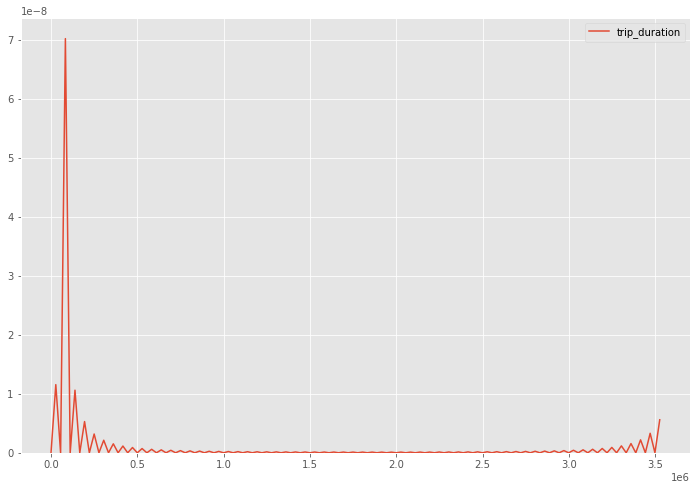

In [11]:
sns.kdeplot(df[target])

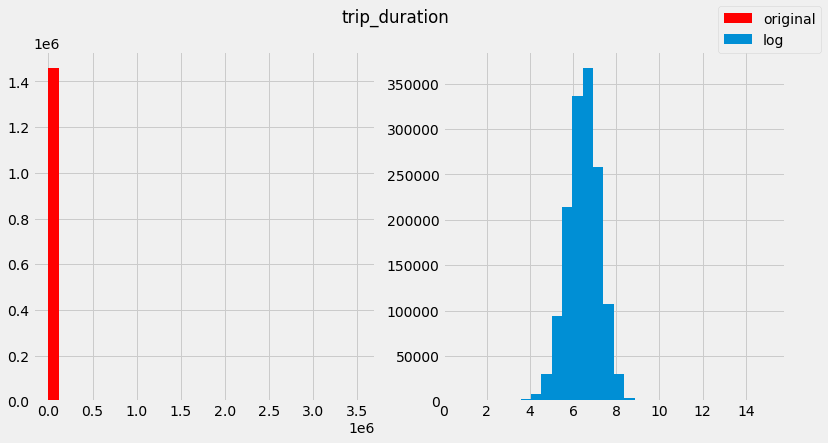

In [267]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].hist(df[target], bins=30, label='original', color='red')
ax[1].hist(np.log1p(df[target]), bins=30, label='log')
fig.suptitle(target)
fig.legend()

In [268]:
np.log1p(df[target]).value_counts()

5.910797     1624
6.013715     1584
5.855072     1582
5.908083     1581
5.883322     1577
             ... 
8.762959        1
11.329435       1
8.637285        1
11.335818       1
10.530361       1
Name: trip_duration, Length: 7417, dtype: int64

## Pairplots

In [13]:
df.dtypes.value_counts()

float64    4
object     4
int64      3
dtype: int64

In [4]:
# Get numerical features
numerical_cols = df.dtypes[df.dtypes != 'object'].index

# Remove the target column
numerical_cols = numerical_cols.drop(['trip_duration'])

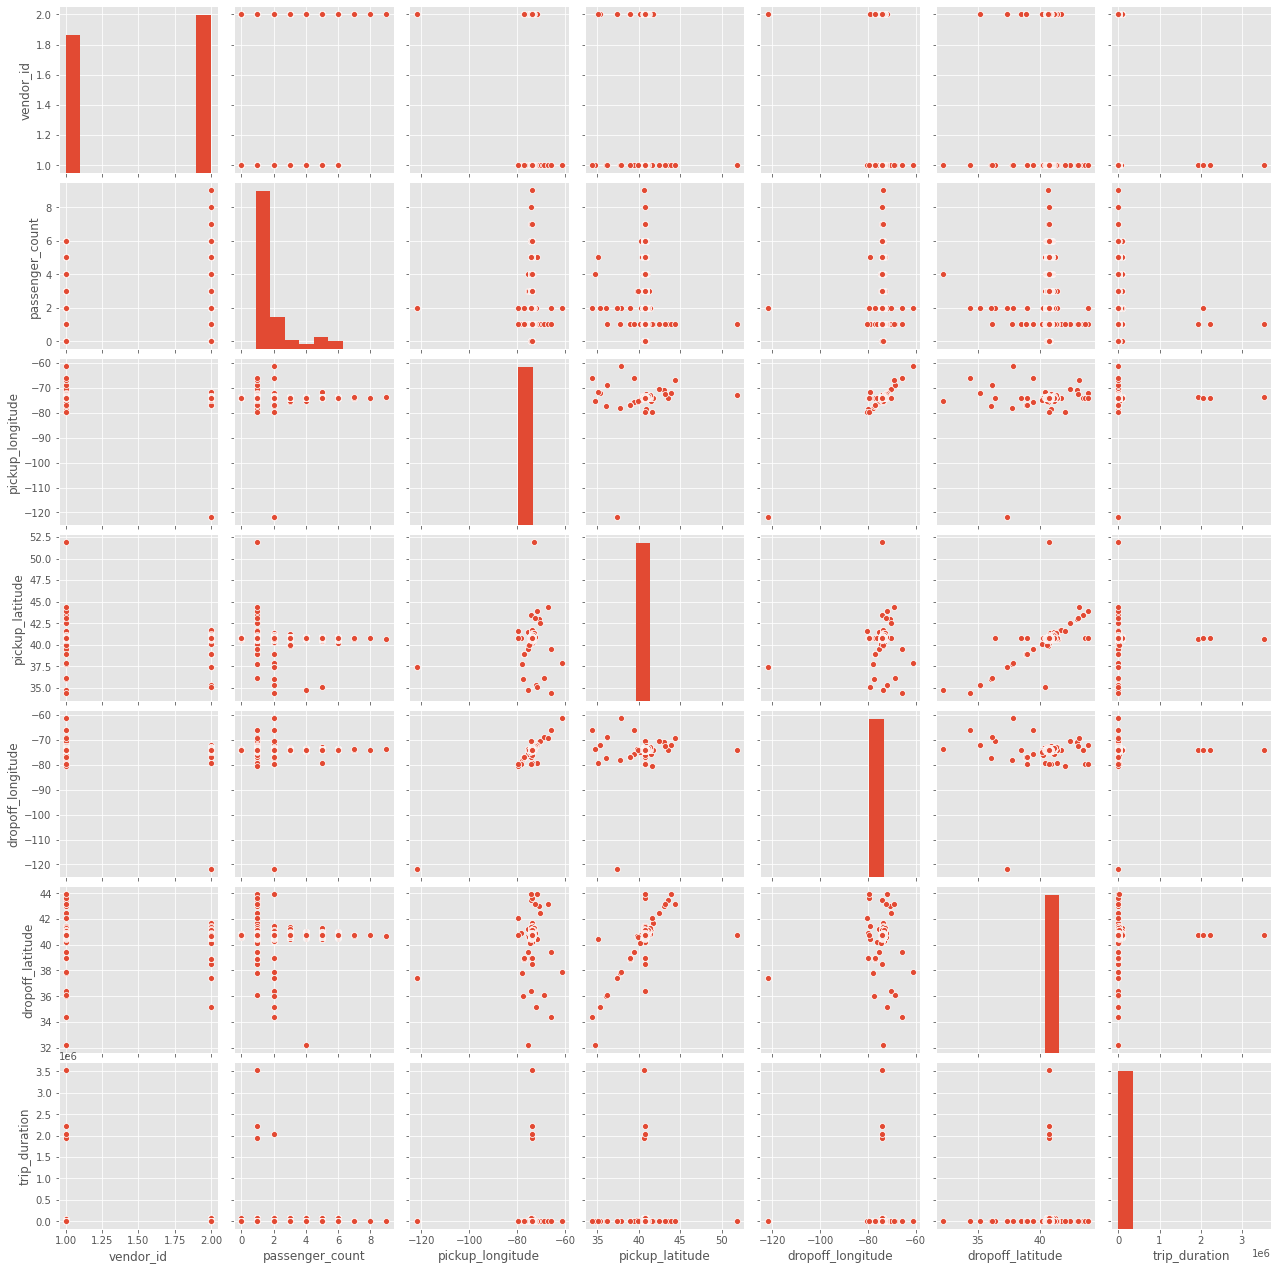

In [15]:
cols = list(numerical_cols) + ['trip_duration']
sns.pairplot(df.loc[:, cols])

## Plot Distribution of all Features and Label

In [ ]:
for feat in ['vendor_id', 'passenger_count']
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].hist(df[target], bins=30, label='original', color='red')
ax[1].hist(np.log1p(df[target]), bins=30, label='log')
fig.suptitle(target)
fig.legend()

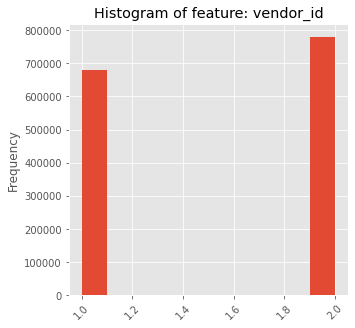

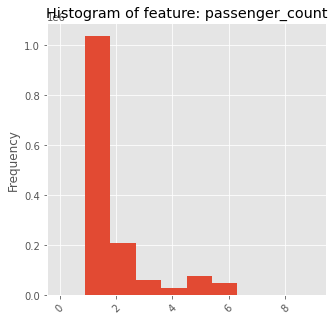

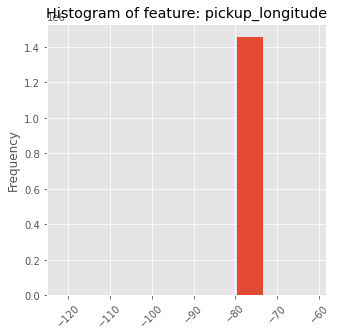

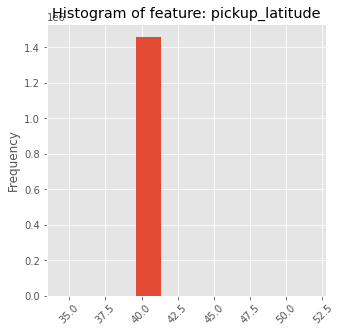

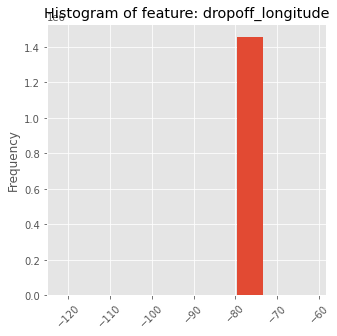

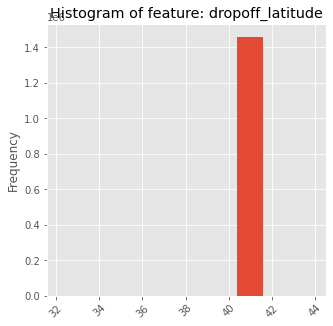

In [16]:
for col in df[numerical_cols].columns:
    fig, ax = plt.subplots(figsize=(5,5))
    df[col].hist(ax=ax)
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of feature: {col}')

## Nulls

In [17]:
null_summary = pd.concat((df.isnull().sum(), df.isnull().sum()/df.shape[0]), axis=1)
null_summary.columns = ['actual', 'pct']
null_summary['dtype'] = df.dtypes
null_summary

actual      pct    dtype
id                       0 0.000000   object
vendor_id                0 0.000000    int64
pickup_datetime          0 0.000000   object
dropoff_datetime         0 0.000000   object
passenger_count          0 0.000000    int64
pickup_longitude         0 0.000000  float64
pickup_latitude          0 0.000000  float64
dropoff_longitude        0 0.000000  float64
dropoff_latitude         0 0.000000  float64
store_and_fwd_flag       0 0.000000   object
trip_duration            0 0.000000    int64

## Correlation Matrix 

Start by creating a random variable to see where this falls in the correlation matrix

In [18]:
df['random'] = np.random.random(df.shape[0])

In [19]:
target_corr = df.corr()['trip_duration'].sort_values()
target_corr

pickup_latitude     -0.029204
dropoff_latitude    -0.020677
random               0.000667
passenger_count      0.008471
dropoff_longitude    0.014678
vendor_id            0.020304
pickup_longitude     0.026542
trip_duration        1.000000
Name: trip_duration, dtype: float64

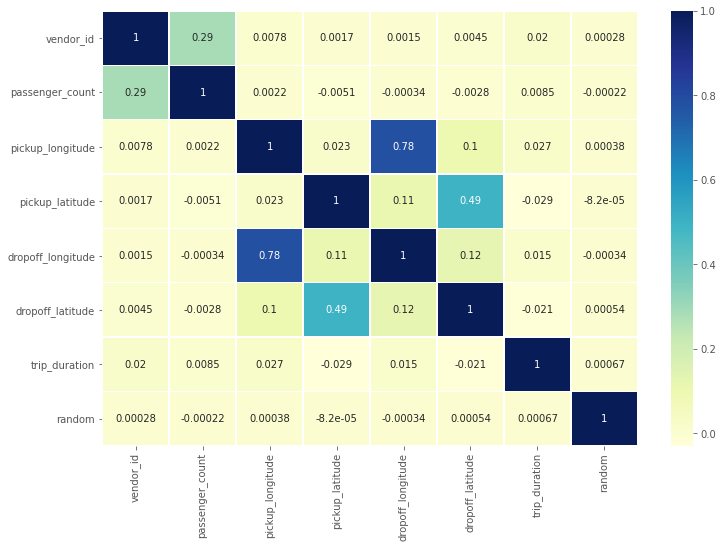

In [20]:
ax = sns.heatmap(df.corr(), annot=True, linewidths=0.5, cmap ='YlGnBu')

## K-means Clustering

### Use Mini Batch K-Means Clustering given large sample size

In [78]:
df_all.shape

(2917288, 7)

In [4]:
df_clusters = df_all[['latitude', 'longitude']].copy()

# Drop lat/longs of extreme outliers below 0.01 percentile or above 99.99 percentile
df_clusters = df_clusters[(df_clusters.quantile(0.0001) < df_clusters) & (df_clusters < df_clusters.quantile(0.9999))]
df_clusters = df_clusters.dropna(how='any')

print(df_clusters.shape)

(2916308, 2)


### Find best 'k'

In [91]:
ssd = []

for k in range(2,20):
    clf = MiniBatchKMeans(n_clusters=k, batch_size=10000, max_iter=300, random_state=1)
    clf.fit(X)
    inertia = clf.inertia_
    ssd.append(inertia)
    print(f'Done with k={k}')
    

Done with k=2
Done with k=3
Done with k=4
Done with k=5
Done with k=6
Done with k=7
Done with k=8
Done with k=9
Done with k=10
Done with k=11
Done with k=12
Done with k=13
Done with k=14
Done with k=15
Done with k=16
Done with k=17
Done with k=18
Done with k=19


Text(0, 0.5, 'Sum of Squared Distances')

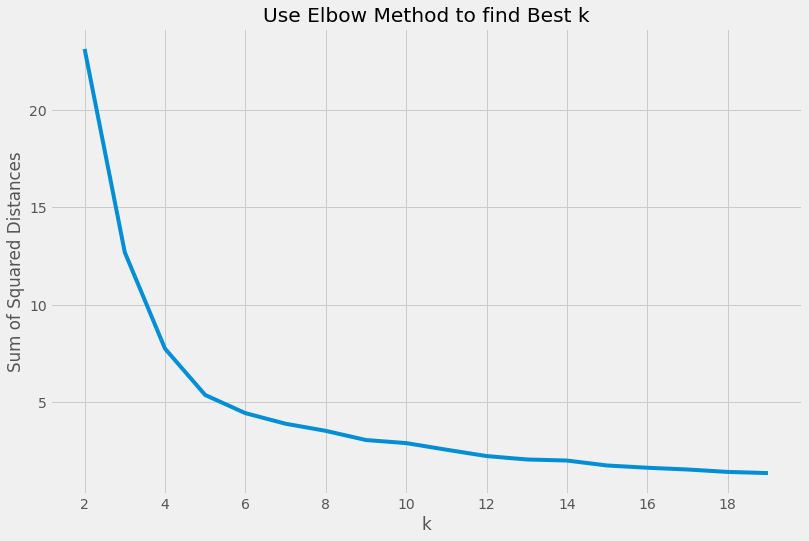

In [92]:
plt.plot(range(2,20), ssd)
plt.xticks(np.arange(2,20,2))
plt.title('Use Elbow Method to find Best k')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')

### Plot random sample of 100k coordinates with their K-means clusters onto map of NYC

In [199]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

In [200]:
def plot_geolocation_by_cluster(df, 
                                cluster=None, 
                                title=None, 
                                centers=None,
                                filename=None):
    '''
    Function to plot latitude and longitude coordinates
    #####################
    Args:
        df: pandas dataframe 
            Contains id, latitude, longitude, and color (optional).
        cluster: (optional) column (string) in df 
            Separate coordinates into different clusters
        title: (optional) string
        centers: (optional) array of coordinates for centers of each cluster
        filename: (optional) string  
    #####################
    Returns:
        Plot with lat/long coordinates 
    '''
    
    # Transform df into geodataframe
    geo_df = gpd.GeoDataFrame(df.drop(['longitude', 'latitude'], axis=1),
                           crs={'init': 'epsg:4326'},
                           geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)])
      
    # Set figure size
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    
    # Import NYC Neighborhood Shape Files
    nyc_full = gpd.read_file('./data_nyc/shapefiles/neighborhoods_nyc.shp')
    nyc_full['nta_name'] = nyc_full['boro_name'] + str('_') + nyc_full['ntaname']
    nyc_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', label=nyc_full['nta_name'], zorder=1)
    nyc_nta = nyc_full[['nta_name', 'geometry']].set_index('nta_name')
    
    # Plot coordinates from geo_df on top of NYC map
    if cluster is not None:
        if centers is not None:
            centers_gseries = GeoSeries(map(Point, zip(centers[:,1], centers[:,0])))
            centers_gseries.plot(ax=ax, alpha=1, marker='X', color='red', markersize=100, zorder=3)
        
        geo_df.plot(ax=ax, column=cluster, alpha=0.5, 
                    cmap='viridis', linewidth=0.8, zorder=2)
       
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
        if filename is not None:
            fig.savefig(f'{filename}', bbox_inches='tight', dpi=300)
    else:
        geo_df.plot(ax=ax, alpha=0.5, cmap='viridis', linewidth=0.8, legend=True, zorder=2)
        
        plt.title(title)
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.show()
        
    fig.clf()
    
    

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



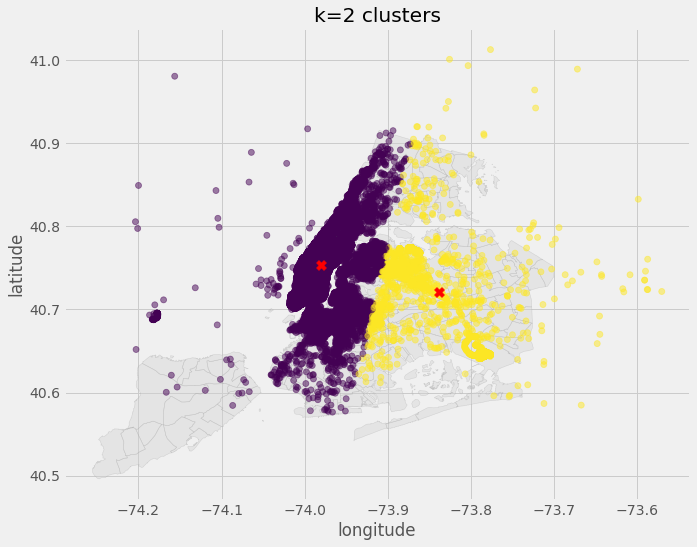

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



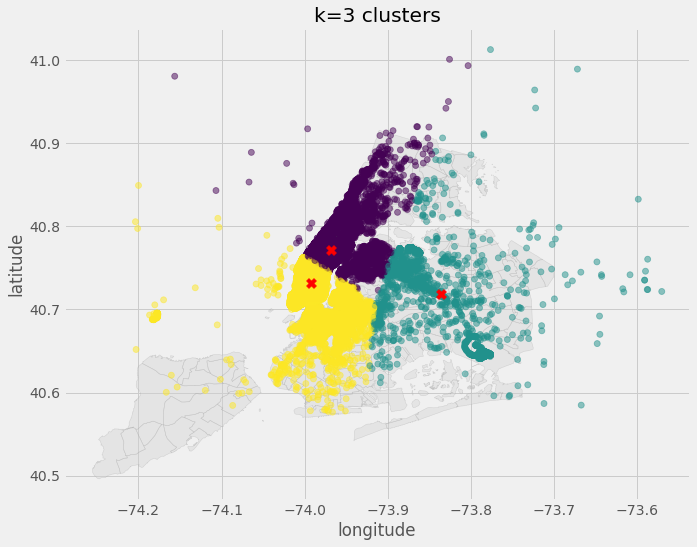

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



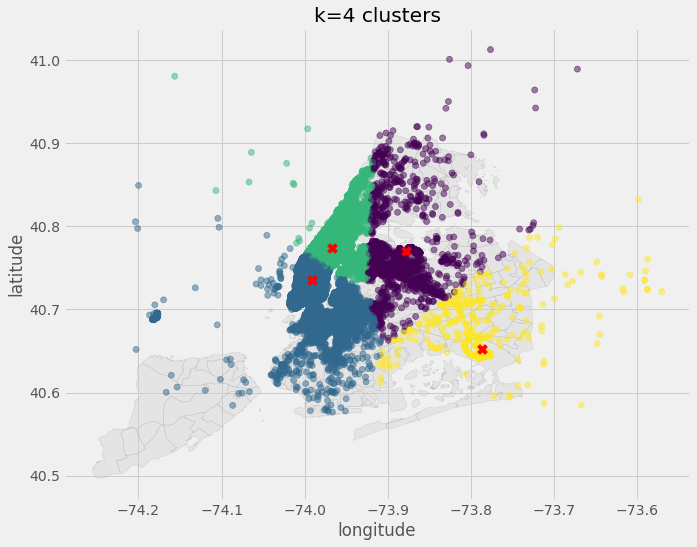

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



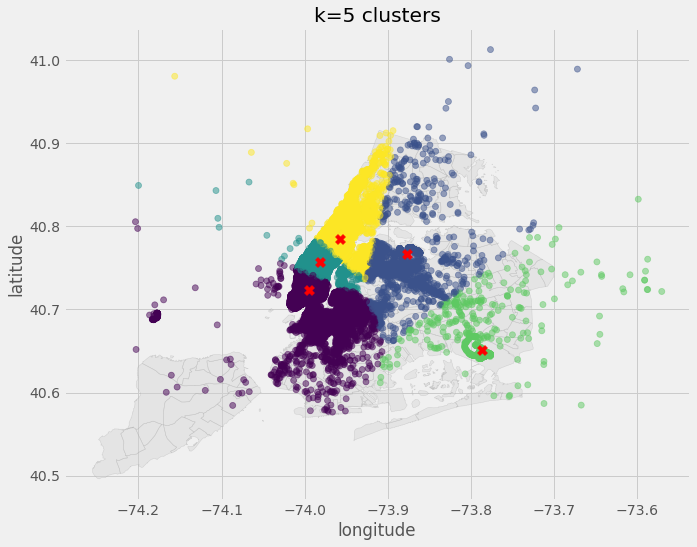

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



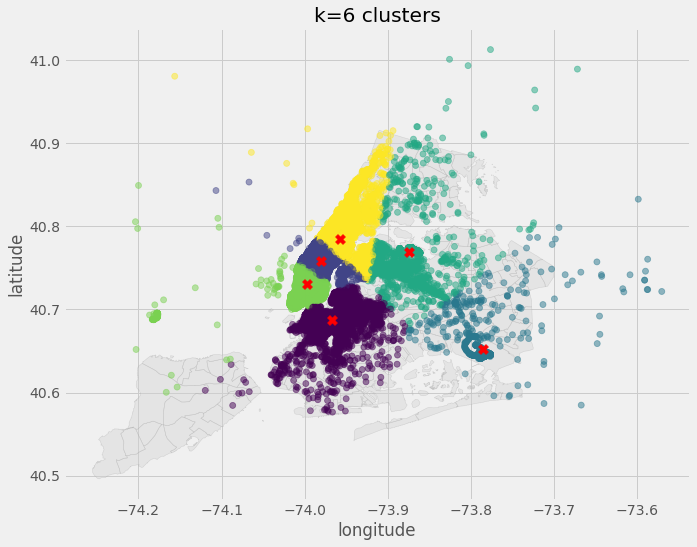

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



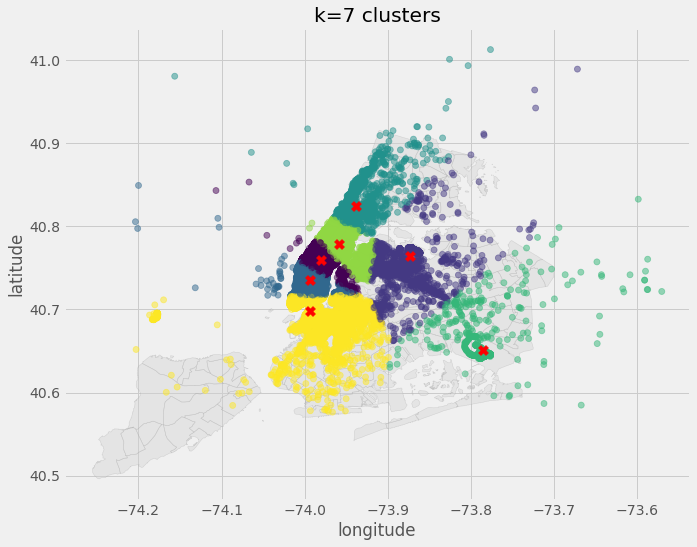

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



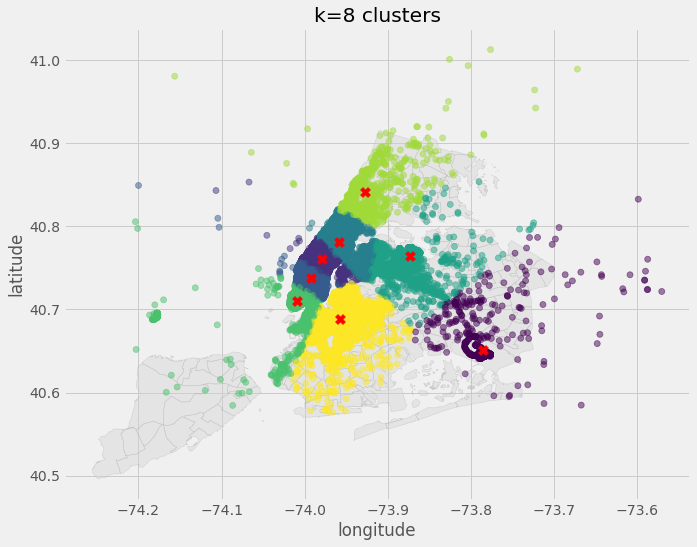

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



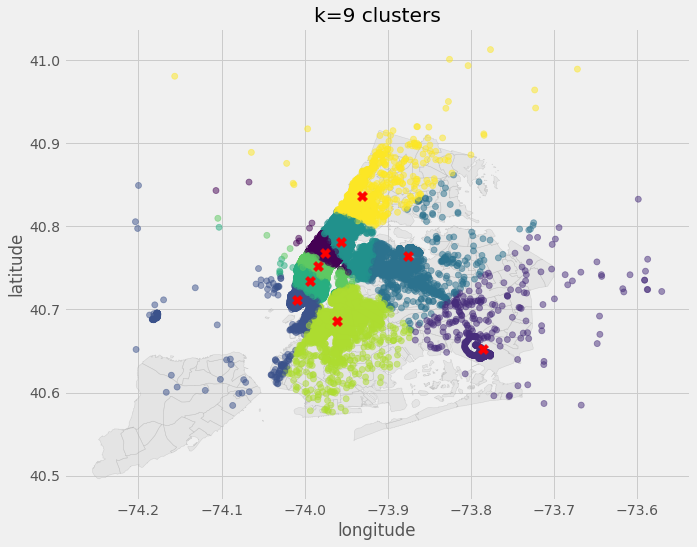

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



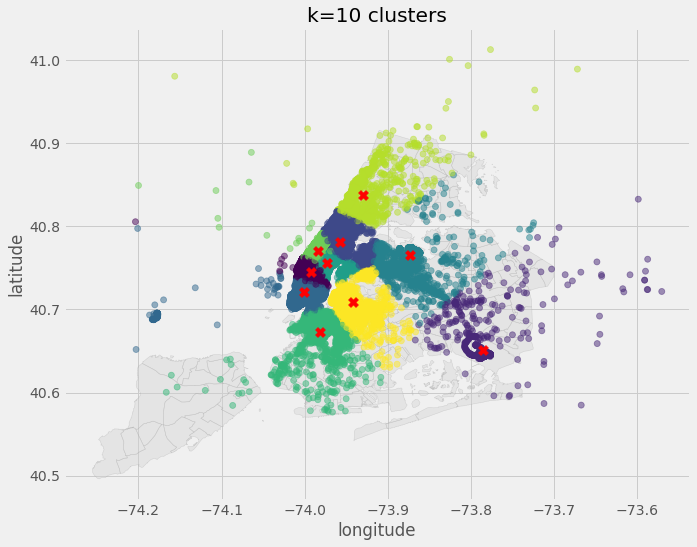

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



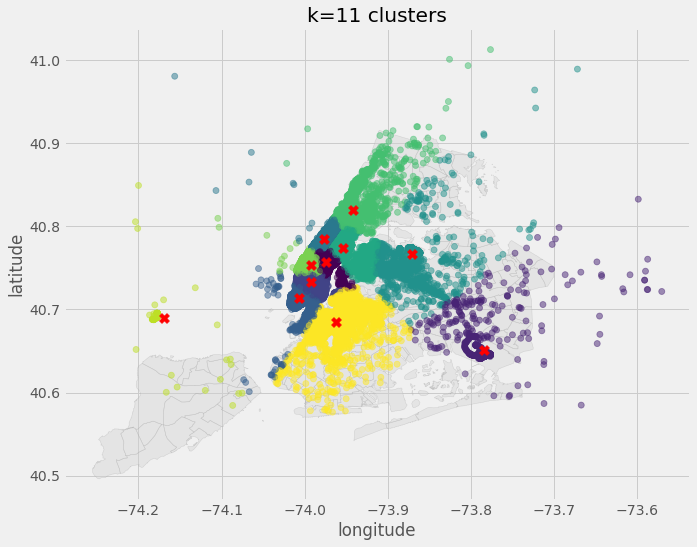

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



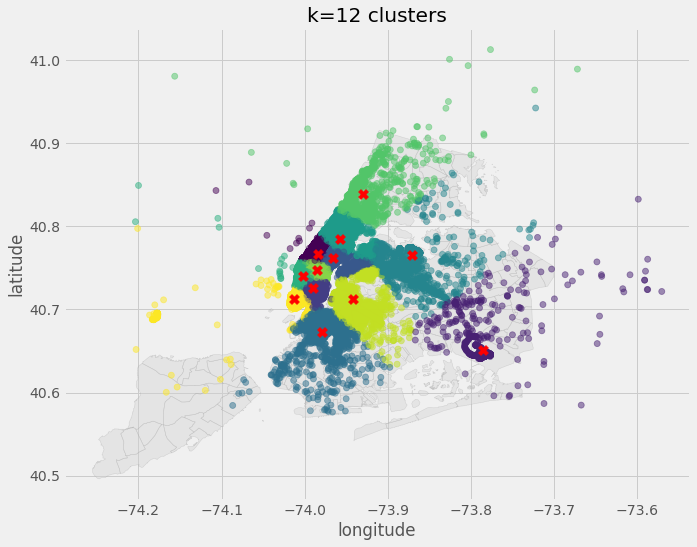

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



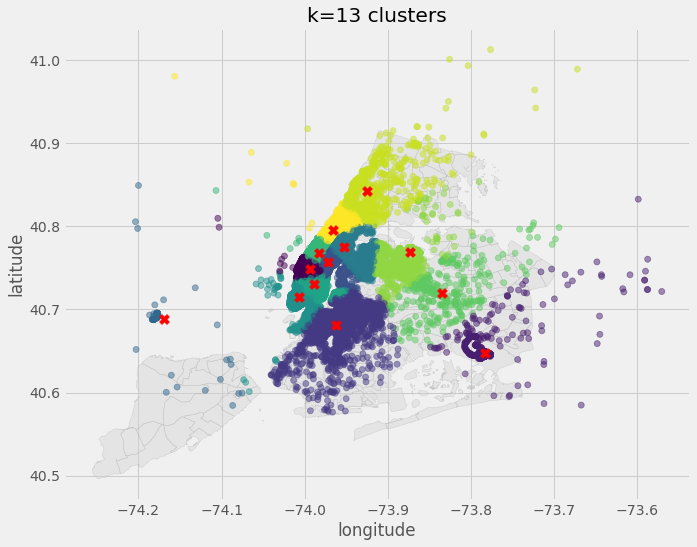

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



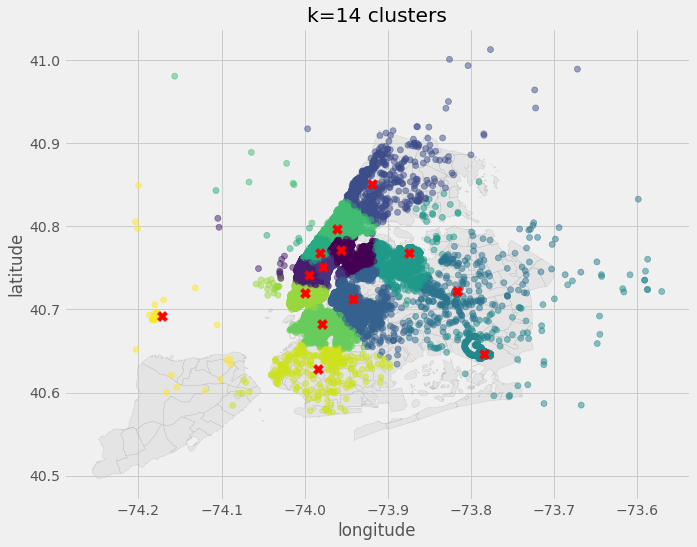

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



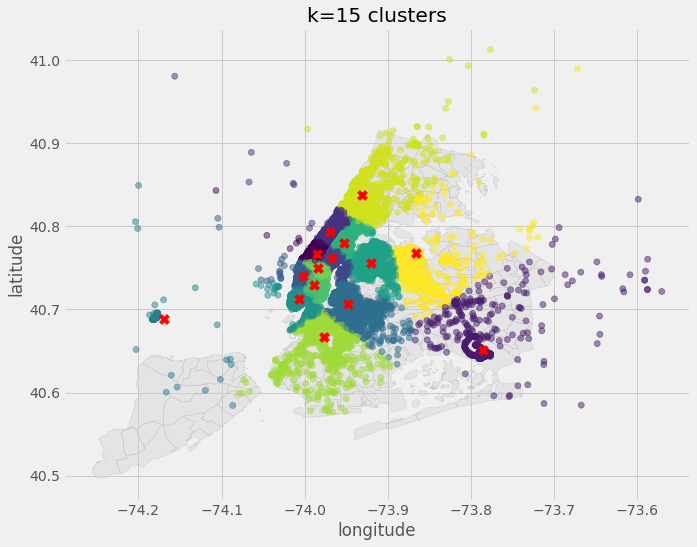

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



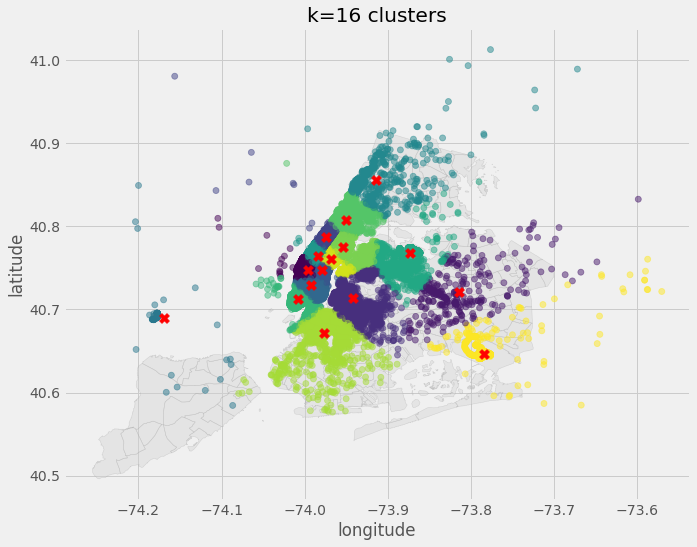

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



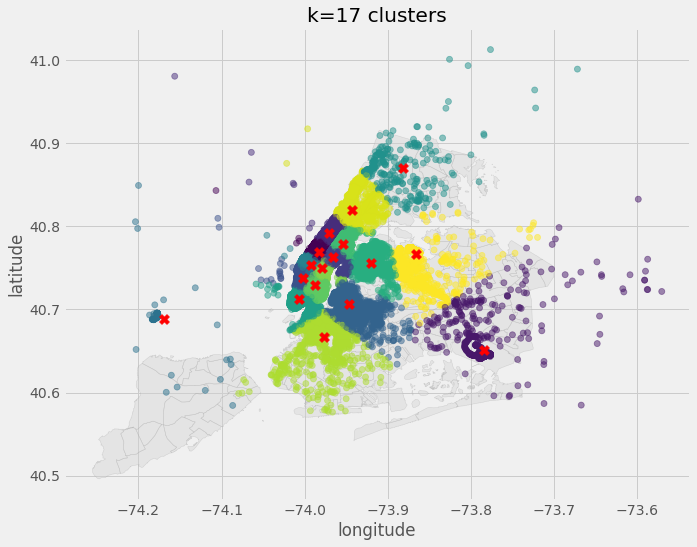

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



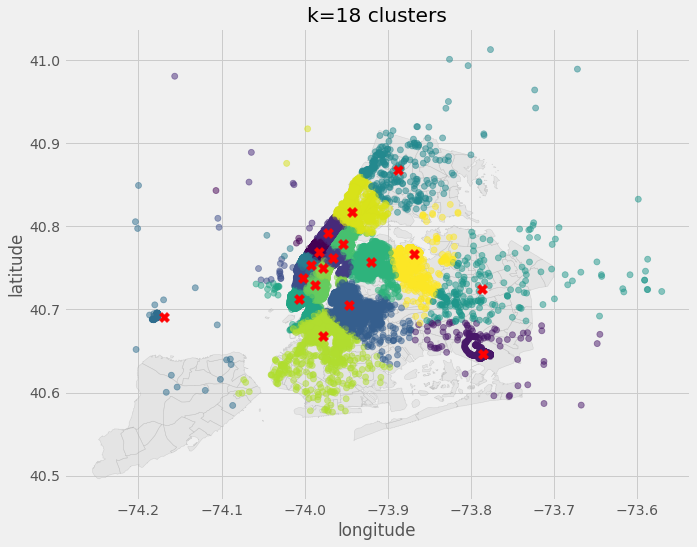

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



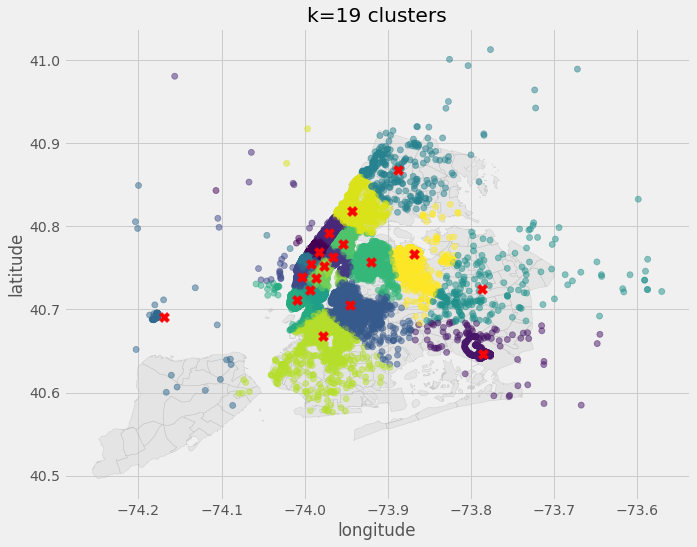

/Users/clau/Documents/Python/env/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



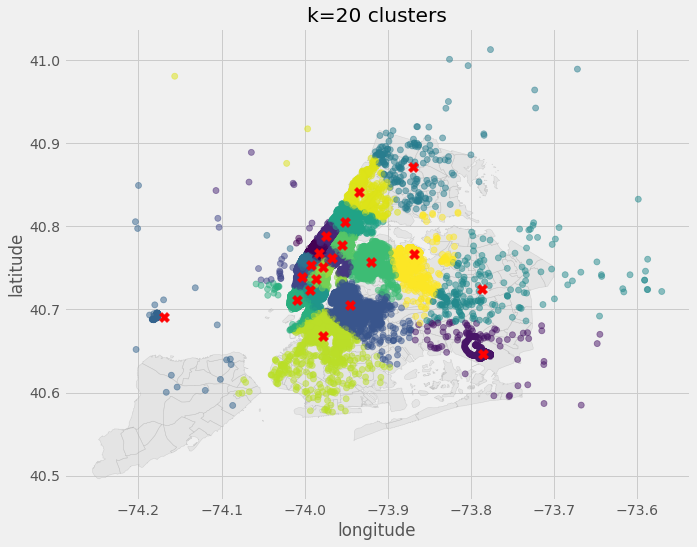

In [159]:
for k in range(2,21):
    df_k = df_clusters.copy()
    clf = MiniBatchKMeans(n_clusters=k, batch_size=10000, max_iter=300, random_state=1)
    clf.fit_predict(df_k)
    
    centers = clf.cluster_centers_
    df_k['cluster'] = clf.labels_
    df_k['cluster'] = df_k['cluster'].astype(str)

    plot_geolocation_by_cluster(df_k.sample(100000, random_state=1), cluster='cluster', title=f'k={k} clusters', centers=centers, filename=f'./plots/kmeans/{k}_kmeans.png')

# Feature Engineering

## Time-based Features

In [8]:
import holidays

In [9]:
class FeaturizeTime(object):
    def fit(self, X, y):
        return self
        
    def transform(self, X):
        X = X.copy()
        X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])
        X['month'] = X['pickup_datetime'].dt.month
        X['day'] = X['pickup_datetime'].dt.day
        X['day_of_week'] = X['pickup_datetime'].dt.dayofweek
        X['hour_of_day'] = X['pickup_datetime'].dt.hour
        X['minute_of_hour'] = X['pickup_datetime'].dt.minute
        
        # Get holidays in NYC in 2016
        us_holidays = holidays.US(state='NY', years=2016)
        X['is_holiday'] = X['pickup_datetime'].dt.date.apply(lambda x: 1 if x in us_holidays.keys() else 0)
        
        # Drop time column in final df
        X = X.drop(['pickup_datetime'], axis=1)
        print('Time-based features transformed')
        return X 


## Calculate Distance Between Coordinates

The original dataset includes latitude and longitude for pickup and dropoff locations. I will use these to engineer the following location-based features:
- __Great Circle Distance between pickup and dropoff locations__ (`great_circle_distance`): I will calculate the great circle distance using geo-py's API between the pickup and dropoff lat/long coordinates - this is the shortest distance between two points on a sphere.


- __Manhattan Distance between pickup and dropoff locations__ (`manhattan_distance`): I will calculate the manhattan distance between the pickup and dropoff lat/long coordinates


- __Bearing between pickup and dropoff locations__ (`bearing`): I will calculate the bearing using geo-py's API between the pickup and dropoff lat/long coordinates - this is the direction from the pickup location to dropoff location.

In [10]:
class FeaturizeLocations(object):
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        ## 1) Find min distance between pickup and dropoff coordinates 
        X['great_circle_distance'] = X.apply(lambda x: self.calculate_great_circle_distance(x['pickup_latitude'], x['pickup_longitude'], 
                                                                       x['dropoff_latitude'], x['dropoff_longitude']),
                                                                       axis=1)
        
        ## 2) Calculate manhattan distance between pickup and dropoff coordinates
        X['manhattan_distance'] = X.apply(lambda x: self.calculate_manhattan_distance(x['pickup_latitude'], x['pickup_longitude'], 
                                                                       x['dropoff_latitude'], x['dropoff_longitude']),
                                                                       axis=1)
        
        ## 3) Calculate bearing between pickup and dropoff latitude
        X['bearing'] = X.apply(lambda x: self.calculate_bearing(x['pickup_latitude'], x['pickup_longitude'], 
                                                           x['dropoff_latitude'], x['dropoff_longitude']),
                                                           axis=1)
        print('Distance features calculated')
        return X
    
    def calculate_great_circle_distance(self, pickup_lat, pickup_long, dropoff_lat, dropoff_long):
        pickup = [pickup_lat, pickup_long]
        dropoff = [dropoff_lat, dropoff_long]
        min_distance = geo.sphere.distance(pickup, dropoff)
        return min_distance
    
    def calculate_manhattan_distance(self, pickup_lat, pickup_long, dropoff_lat, dropoff_long):
        pickup = [pickup_lat, pickup_long]
        dropoff_a = [pickup_lat, dropoff_long]
        dropoff_b = [dropoff_lat, pickup_long]
        haversine_a = geo.sphere.haversine_distance(pickup, dropoff_a)
        haversine_b = geo.sphere.haversine_distance(pickup, dropoff_b)
        return haversine_a + haversine_b
        
    def calculate_bearing(self, pickup_lat, pickup_long, dropoff_lat, dropoff_long):
        pickup = [pickup_lat, pickup_long]
        dropoff = [dropoff_lat, dropoff_long]
        bearing = geo.sphere.bearing(pickup, dropoff)
        return bearing

## Find Cluster

In [128]:
class ClusterLocations():
    def __init__(self):
        self.pickup_time_clusters = pd.DataFrame()
        self.dropoff_time_clusters = pd.DataFrame()
    
    def fit(self, X, y):
        # Calculate pickup time cluster
        df_pickup = X[['pickup_latitude', 'pickup_longitude']].copy()       
        # Initialize K-means 
        self.clf_pickup = MiniBatchKMeans(n_clusters=20, batch_size=10000, max_iter=300, random_state=1)
        self.clf_pickup.fit_predict(df_pickup)
        df_pickup['pickup_cluster'] = self.clf_pickup.labels_
        df_pickup['pickup_cluster'] = df_pickup['pickup_cluster'].astype(str)
        X = pd.merge(X, df_pickup[['pickup_cluster']], left_index=True, right_index=True, how='left')
        self.clf_pickup.fit(df_pickup.drop(['pickup_cluster'], axis=1))
        # Calculate number of rides grouped by cluster and time as a proxy for "density" of traffic by location and time
        pickup_time_clusters = pd.DataFrame(X.groupby(['pickup_cluster', 'day_of_week', 'hour_of_day'])['pickup_latitude'].count()).reset_index()
        pickup_time_clusters = pickup_time_clusters.rename(columns={'pickup_latitude': 'num_rides_by_pickup_group'})
        pickup_time_clusters['perc_rides_by_pickup_group'] = pickup_time_clusters['num_rides_by_pickup_group']/ pickup_time_clusters['num_rides_by_pickup_group'].sum()
        pickup_time_clusters['pickup_group'] = pickup_time_clusters['pickup_cluster'].map(str) + str(',') + pickup_time_clusters['day_of_week'].map(str) + str(',') + pickup_time_clusters['hour_of_day'].map(str)
        self.pickup_time_clusters = pickup_time_clusters
        
        # Calculate dropoff time cluster
        df_dropoff = X[['dropoff_latitude', 'dropoff_longitude']].copy()       
        # Initialize K-means 
        self.clf_dropoff = MiniBatchKMeans(n_clusters=20, batch_size=10000, max_iter=300, random_state=1)
        self.clf_dropoff.fit_predict(df_dropoff)
        df_dropoff['dropoff_cluster'] = self.clf_dropoff.labels_
        df_dropoff['dropoff_cluster'] = df_dropoff['dropoff_cluster'].astype(str)
        X = pd.merge(X, df_dropoff[['dropoff_cluster']], left_index=True, right_index=True, how='left')
        self.clf_dropoff.fit(df_dropoff.drop(['dropoff_cluster'], axis=1))
        # Calculate number of rides grouped by cluster and time as a proxy for "density" of traffic by location and time
        dropoff_time_clusters = pd.DataFrame(X.groupby(['dropoff_cluster', 'day_of_week', 'hour_of_day'])['dropoff_latitude'].count()).reset_index()
        dropoff_time_clusters = dropoff_time_clusters.rename(columns={'dropoff_latitude': 'num_rides_by_dropoff_group'})
        dropoff_time_clusters['perc_rides_by_dropoff_group'] = dropoff_time_clusters['num_rides_by_dropoff_group']/ dropoff_time_clusters['num_rides_by_dropoff_group'].sum()
        dropoff_time_clusters['dropoff_group'] = dropoff_time_clusters['dropoff_cluster'].map(str) + str(',') + dropoff_time_clusters['day_of_week'].map(str) + str(',') + dropoff_time_clusters['hour_of_day'].map(str)
        self.dropoff_time_clusters = dropoff_time_clusters
        
        return self
    
    def transform(self, X):
        
        df_pickup = X[['pickup_latitude', 'pickup_longitude']].copy()
        # Add cluster label
        df_pickup['pickup_cluster'] = self.clf_pickup.predict(df_pickup)
        df_pickup['pickup_cluster'] = df_pickup['pickup_cluster'].astype(str)
        # Merge cluster label back to original dataframe
        X = pd.merge(X, df_pickup[['pickup_cluster']], left_index=True, right_index=True, how='left')
        # Merge to create "num_rides_by_pickup_group" and "perc_rides_by_pickup_group" features
        X['pickup_group'] = X['pickup_cluster'].map(str) + str(',') + X['day_of_week'].map(str) + str(',') + X['hour_of_day'].map(str)
        X = pd.merge(X, self.pickup_time_clusters[['pickup_group','num_rides_by_pickup_group', 'perc_rides_by_pickup_group']], on='pickup_group', how='left')
        X = X.drop(['pickup_group'], axis=1)
        print('Pickup Clusters Found')
        
        df_dropoff = X[['dropoff_latitude', 'dropoff_longitude']].copy() 
        # Add cluster label
        df_dropoff['dropoff_cluster'] = self.clf_dropoff.predict(df_dropoff)
        df_dropoff['dropoff_cluster'] = df_dropoff['dropoff_cluster'].astype(str)
        # Merge cluster label back to original dataframe
        X = pd.merge(X, df_dropoff[['dropoff_cluster']], left_index=True, right_index=True, how='left')
        # Merge to create "num_rides_by_pickup_group" and "perc_rides_by_pickup_group" features
        X['dropoff_group'] = X['dropoff_cluster'].map(str) + str(',') + X['day_of_week'].map(str) + str(',') + X['hour_of_day'].map(str)
        X = pd.merge(X, self.dropoff_time_clusters[['dropoff_group','num_rides_by_dropoff_group', 'perc_rides_by_dropoff_group']], on='dropoff_group', how='left')
        X = X.drop(['dropoff_group'], axis=1)
        print('Dropoff Clusters Found')
        
        return X

## Dummify Categorical Features

In [311]:
class DummifyCategoricals():
    def fit(self, X, y):
        self.cols_to_encode=['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_cluster', 'dropoff_cluster']
        self.encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')
        
        transformed_array = self.encoder.fit_transform(X[self.cols_to_encode]).toarray()
        self.transformed_colnames = [f'{prefix}_{value}' for prefix, values in zip(self.cols_to_encode, self.encoder.categories_) for value in values]
            
        return self
        
    def transform(self, X):
        transformed_array = self.encoder.transform(X[self.cols_to_encode]).toarray()
        transformed_df = pd.DataFrame(transformed_array, columns=self.transformed_colnames)
        
        X = pd.concat((X.drop(self.cols_to_encode, axis=1).reset_index(drop=True), transformed_df.reset_index(drop=True)), axis=1)
        print('Categorical variables dummified')
        return X

# Modeling

## Super Naive Model

What is the RMSLE if we predicted the mean trip duration for our dataset?

In [97]:
y_preds_super_naive = np.repeat(df['trip_duration'].mean(), df.shape[0])
y_preds_super_naive

array([959.49227296, 959.49227296, 959.49227296, ..., 959.49227296,
       959.49227296, 959.49227296])

In [98]:
np.sqrt(mean_squared_log_error(df['trip_duration'], y_preds_super_naive))

0.890846228918568

## Naive Model

No feature engineering; just modeling with cross validation

In [125]:
rf_cv_mean = np.sqrt(-cross_val_score(estimator=RandomForestRegressor(),
                X=df[numerical_cols].sample(10000, random_state=1), 
                y=df[target].sample(10000, random_state=1),
                scoring='neg_mean_squared_log_error').mean())


In [126]:
print(f'Random Forest CV Mean RMSLE: {rf_cv_mean}')

Random Forest CV Mean RMSLE: 0.618445870491238


## Model with Feature Engineering

## Transform label to log scale

In [13]:
df['trip_duration_log'] = np.log1p(df['trip_duration'])

In [14]:
target = 'trip_duration_log'

## Train, test split

In [15]:
df_train, df_test = train_test_split(df)

In [16]:
# Remove original target from df_train and df_test
df_train = df_train.drop(['trip_duration'], axis=1)
df_test = df_test.drop(['trip_duration'], axis=1)

In [17]:
df_train.shape, df_test.shape

((1093983, 11), (364661, 11))

In [18]:
df_train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
222378   id0441942          2  2016-04-19 08:08:32  2016-04-19 08:40:01   
1015564  id2690778          1  2016-06-06 21:26:42  2016-06-06 21:52:04   
605022   id3059035          2  2016-04-06 17:04:18  2016-04-06 17:09:10   
1438432  id3942686          2  2016-06-02 19:22:59  2016-06-02 19:27:13   
270010   id1682375          2  2016-06-25 00:11:05  2016-06-25 00:25:20   

         passenger_count  pickup_longitude  pickup_latitude  \
222378                 2        -73.989983        40.747200   
1015564                2        -73.863533        40.769909   
605022                 1        -73.984474        40.745491   
1438432                1        -73.969437        40.758163   
270010                 4        -73.970451        40.756390   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
222378          -73.873390         40.774422                  N   
1015564         -74.009697         40.709774                  N   
605022          -73.978622         40.750763                  N   
1438432         -73.964554         40.769806                  N   
270010          -73.949829         40.784370                  N   

         trip_duration_log  
222378            7.544332  
1015564           7.328437  
605022            5.680173  
1438432           5.541264  
270010            6.752270

In [19]:
initial_feats = ['vendor_id',
                 'pickup_datetime',
                 'passenger_count',
                 'pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude',
                 'store_and_fwd_flag']

## Data Preprocessing

In [312]:
half_pipeline = make_pipeline(FeaturizeTime(),
                         FeaturizeLocations(),
                         ClusterLocations(),
                         DummifyCategoricals())

In [313]:
df_train_feat = half_pipeline.fit_transform(df_train[initial_feats])
df_test_feat = half_pipeline.fit_transform(df_test[initial_feats])

Time-based features transformed
Distance features calculated
Pickup Clusters Found
Dropoff Clusters Found
Categorical variables dummified
Time-based features transformed
Distance features calculated
Pickup Clusters Found
Dropoff Clusters Found
Categorical variables dummified


In [314]:
df_train_feat.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.989983        40.747200         -73.873390         40.774422   
1        -73.863533        40.769909         -74.009697         40.709774   
2        -73.984474        40.745491         -73.978622         40.750763   
3        -73.969437        40.758163         -73.964554         40.769806   
4        -73.970451        40.756390         -73.949829         40.784370   

   month  day  day_of_week  hour_of_day  minute_of_hour  is_holiday  \
0      4   19            1            8               8           0   
1      6    6            0           21              26           0   
2      4    6            2           17               4           0   
3      6    2            3           19              22           0   
4      6   25            5            0              11           0   

   great_circle_distance  manhattan_distance     bearing  \
0           12991.543935        13799.342130    3.710541   
1           16357.684545        18111.120496  186.465723   
2             670.491357          812.419562   13.963476   
3             650.102092          900.444161   33.372217   
4            2448.943257         3152.233587   20.564424   

   num_rides_by_pickup_group  perc_rides_by_pickup_group  \
0                        451                    0.000412   
1                        288                    0.000263   
2                        488                    0.000446   
3                       1102                    0.001007   
4                        479                    0.000438   

   num_rides_by_dropoff_group  perc_rides_by_dropoff_group  vendor_id_1  \
0                         121                     0.000111          0.0   
1                         291                     0.000266          1.0   
2                        1214                     0.001110          0.0   
3                        1503                     0.001374          0.0   
4                         737                     0.000674          0.0   

   vendor_id_2  passenger_count_0  passenger_count_1  passenger_count_2  \
0          1.0                0.0                0.0                1.0   
1          0.0                0.0                0.0                1.0   
2          1.0                0.0                1.0                0.0   
3          1.0                0.0                1.0                0.0   
4          1.0                0.0                0.0                0.0   

   passenger_count_3  passenger_count_4  passenger_count_5  passenger_count_6  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0                0.0   
2                0.0                0.0                0.0                0.0   
3                0.0                0.0                0.0                0.0   
4                0.0                1.0                0.0                0.0   

   passenger_count_7  passenger_count_9  store_and_fwd_flag_N  \
0                0.0                0.0                   1.0   
1                0.0                0.0                   1.0   
2                0.0                0.0                   1.0   
3                0.0                0.0                   1.0   
4                0.0                0.0                   1.0   

   store_and_fwd_flag_Y  pickup_cluster_0  pickup_cluster_1  \
0                   0.0               0.0               0.0   
1                   0.0               0.0               0.0   
2                   0.0               0.0               0.0   
3                   0.0               0.0               0.0   
4                   0.0               0.0               0.0   

   pickup_cluster_10  pickup_cluster_11  pickup_cluster_12  pickup_cluster_13  \
0                0.0                0.0                0.0                0.0   
1                0.0                0.0                0.0            

## Pipeline LightGBM Model

In [406]:
lgb = LGBMRegressor(eval_metric='rmse')
lgb.fit(df_train_feat, df_train[target])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='rmse', importance_type='split', learning_rate=0.1,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [407]:
y_preds_lgbm = lgb.predict(df_test_feat)

In [408]:
calc_rmsle(df_test[target], y_preds_lgbm)

0.42565021466136876

# Hyperparameter Tuning and Feature Selection

## Feature Selection

In [409]:
np.argsort(lgb.feature_importances_)[::-1]

array([12,  7,  3,  1, 11,  2, 10,  6,  0, 13, 15,  4,  5,  9, 17, 34,  8,
       18, 59, 20, 69, 51, 62, 67, 63, 50, 42, 49, 19, 35, 47, 56, 65, 32,
       61, 53, 45, 40, 52, 33, 41, 43, 48, 64, 21, 36, 38, 57, 39, 46, 44,
       14, 66, 60, 58, 16, 55, 68, 54, 37, 22, 23, 24, 25, 27, 28, 29, 30,
       31, 26])

In [410]:
best_feats = df_train_feat.columns[np.argsort(lgb.feature_importances_)[::-1]]
best_feats

Index(['bearing', 'hour_of_day', 'dropoff_latitude', 'pickup_latitude',
       'manhattan_distance', 'dropoff_longitude', 'great_circle_distance',
       'day_of_week', 'pickup_longitude', 'num_rides_by_pickup_group',
       'num_rides_by_dropoff_group', 'month', 'day', 'is_holiday',
       'vendor_id_1', 'pickup_cluster_12', 'minute_of_hour', 'vendor_id_2',
       'dropoff_cluster_17', 'passenger_count_1', 'dropoff_cluster_9',
       'dropoff_cluster_1', 'dropoff_cluster_2', 'dropoff_cluster_7',
       'dropoff_cluster_3', 'dropoff_cluster_0', 'pickup_cluster_2',
       'pickup_cluster_9', 'passenger_count_0', 'pickup_cluster_13',
       'pickup_cluster_7', 'dropoff_cluster_14', 'dropoff_cluster_5',
       'pickup_cluster_10', 'dropoff_cluster_19', 'dropoff_cluster_11',
       'pickup_cluster_5', 'pickup_cluster_18', 'dropoff_cluster_10',
       'pickup_cluster_11', 'pickup_cluster_19', 'pickup_cluster_3',
       'pickup_cluster_8', 'dropoff_cluster_4', 'passenger_count_2',
       'pi

In [411]:
features_intersection = [col for col in df_train_feat[df_train_feat.columns.intersection(df_test_feat.columns)].columns]

In [412]:
best_feats_intersection = [feat for feat in best_feats if feat in features_intersection]
print(len(best_feats_intersection))
best_feats_intersection

69


['bearing',
 'hour_of_day',
 'dropoff_latitude',
 'pickup_latitude',
 'manhattan_distance',
 'dropoff_longitude',
 'great_circle_distance',
 'day_of_week',
 'pickup_longitude',
 'num_rides_by_pickup_group',
 'num_rides_by_dropoff_group',
 'month',
 'day',
 'is_holiday',
 'vendor_id_1',
 'pickup_cluster_12',
 'minute_of_hour',
 'vendor_id_2',
 'dropoff_cluster_17',
 'passenger_count_1',
 'dropoff_cluster_9',
 'dropoff_cluster_1',
 'dropoff_cluster_2',
 'dropoff_cluster_7',
 'dropoff_cluster_3',
 'dropoff_cluster_0',
 'pickup_cluster_2',
 'pickup_cluster_9',
 'passenger_count_0',
 'pickup_cluster_13',
 'pickup_cluster_7',
 'dropoff_cluster_14',
 'dropoff_cluster_5',
 'pickup_cluster_10',
 'dropoff_cluster_19',
 'dropoff_cluster_11',
 'pickup_cluster_5',
 'pickup_cluster_18',
 'dropoff_cluster_10',
 'pickup_cluster_11',
 'pickup_cluster_19',
 'pickup_cluster_3',
 'pickup_cluster_8',
 'dropoff_cluster_4',
 'passenger_count_2',
 'pickup_cluster_14',
 'pickup_cluster_16',
 'dropoff_cluster_15',
 'pickup_cluster_17',
 'pickup_cluster_6',
 'pickup_cluster_4',
 'perc_rides_by_pickup_group',
 'dropoff_cluster_6',
 'dropoff_cluster_18',
 'dropoff_cluster_16',
 'perc_rides_by_dropoff_group',
 'dropoff_cluster_13',
 'dropoff_cluster_8',
 'dropoff_cluster_12',
 'pickup_cluster_15',
 'passenger_count_3',
 'passenger_count_4',
 'passenger_count_5',
 'passenger_count_6',
 'store_and_fwd_flag_N',
 'store_and_fwd_flag_Y',
 'pickup_cluster_0',
 'pickup_cluster_1',
 'passenger_count_7']

In [413]:
train_scores = []
test_scores = []

for i in range(1, len(best_feats_intersection)):
    lgb.fit(df_train_feat.loc[:, best_feats_intersection[:i]], df_train[target])
    train_preds = lgb.predict(df_train_feat.loc[:, best_feats_intersection[:i]])
    train_scores.append(calc_rmsle(df_train[target],train_preds))
    test_preds = lgb.predict(df_test_feat.loc[:, best_feats_intersection[:i]])
    test_scores.append(calc_rmsle(df_test[target], test_preds))
    print(f'RMSLE recorded for round {i}')

RMSLE recorded for round 1
RMSLE recorded for round 2
RMSLE recorded for round 3
RMSLE recorded for round 4
RMSLE recorded for round 5
RMSLE recorded for round 6
RMSLE recorded for round 7
RMSLE recorded for round 8
RMSLE recorded for round 9
RMSLE recorded for round 10
RMSLE recorded for round 11
RMSLE recorded for round 12
RMSLE recorded for round 13
RMSLE recorded for round 14
RMSLE recorded for round 15
RMSLE recorded for round 16
RMSLE recorded for round 17
RMSLE recorded for round 18
RMSLE recorded for round 19
RMSLE recorded for round 20
RMSLE recorded for round 21
RMSLE recorded for round 22
RMSLE recorded for round 23
RMSLE recorded for round 24
RMSLE recorded for round 25
RMSLE recorded for round 26
RMSLE recorded for round 27
RMSLE recorded for round 28
RMSLE recorded for round 29
RMSLE recorded for round 30
RMSLE recorded for round 31
RMSLE recorded for round 32
RMSLE recorded for round 33
RMSLE recorded for round 34
RMSLE recorded for round 35
RMSLE recorded for round 36
R

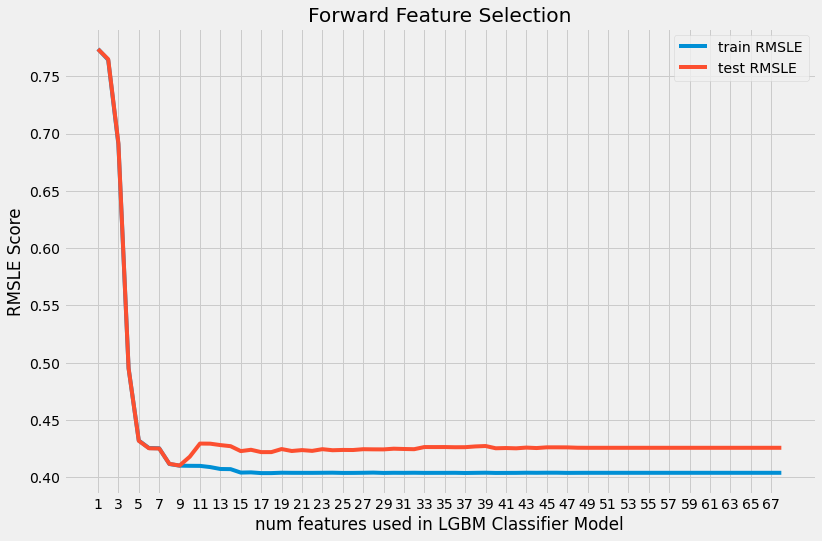

In [414]:
plt.plot(range(1, len(best_feats_intersection)), train_scores, label='train RMSLE')
plt.plot(range(1, len(best_feats_intersection)), test_scores, label='test RMSLE')

plt.xticks(np.arange(1,len(best_feats_intersection),2))
plt.xlabel('num features used in LGBM Classifier Model')
plt.ylabel('RMSLE Score')
plt.legend()
plt.title('Forward Feature Selection')
plt.savefig('./plots/step_forward_feat_sel.png', bbox_inches='tight')

In [415]:
min(test_scores)

0.41015179186032386

In [416]:
best_n_feats = test_scores.index(min(test_scores)) + 1

In [417]:
X_train = df_train_feat.loc[:, best_feats_intersection[:best_n_feats]]
X_test = df_test_feat.loc[:, best_feats_intersection[:best_n_feats]]

y_train = df_train[target]
y_test = df_test[target]

In [418]:
X_train.shape, X_test.shape

((1093983, 8), (364661, 8))

## Hyperparameter Tuning

In [440]:
params = {
    'num_leaves': [81,91,121], 
    'max_depth': [5,6,8], 
    'n_estimators': [150,160,190],
    'reg_alpha': [0.05]
}


In [441]:
rmsle_scorer = metrics.make_scorer(calc_rmsle, greater_is_better=False)

In [442]:
lgb = LGBMRegressor(eval_metric='rmse')
clf = GridSearchCV(lgb, params, scoring=rmsle_scorer)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, eval_metric='rmse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 6, 8],
                         'n_estimators': [150, 160, 190],
                         'num_leaves': [81, 91, 12

In [443]:
clf.best_params_

{'max_depth': 8, 'n_estimators': 190, 'num_leaves': 121, 'reg_alpha': 0.05}

In [444]:
clf.best_score_

-0.4014912212179097

In [445]:
pd.DataFrame.from_dict(clf.cv_results_).sort_values(by='mean_test_score')

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        4.225536      0.749182         1.179429        0.572209   
1        5.939231      2.996062         0.825460        0.063776   
2        4.481129      0.819869         0.913287        0.153529   
3        5.081711      0.625953         1.145887        0.575742   
4        4.313452      0.363764         0.955894        0.192808   
5        4.023639      0.073219         0.819650        0.015149   
6        4.559741      0.122884         0.998471        0.017790   
7        4.762878      0.303060         1.036507        0.087550   
8        4.672751      0.080193         1.028483        0.100245   
9        4.425080      0.135435         0.914026        0.033360   
10       4.468393      0.120288         0.951481        0.039696   
11       4.607132      0.191587         0.988502        0.040748   
14       4.751459      0.275214         0.969920        0.015673   
13       4.751114      0.203604         0.972271        0.028247   
12       5.008009      0.367561         1.075348        0.122872   
15       5.210862      0.103573         1.138591        0.021447   
16       5.318667      0.077340         1.197606        0.028353   
17       5.487136      0.550652         1.147114        0.027352   
18       5.506072      0.585696         1.069835        0.090218   
21       6.191903      0.268955         1.312651        0.080112   
19       5.849227      0.377326         1.307955        0.309013   
22       5.933915      0.356776         1.165047        0.071521   
24       5.664028      0.026733         1.223038        0.012021   
20       6.046412      0.385755         1.248422        0.108292   
25       6.380867      0.260477         1.327112        0.045328   
23       5.863428      0.212546         1.213837        0.015840   
26       7.845171      0.478979         1.634324        0.136237   

   param_max_depth param_n_estimators param_num_leaves param_reg_alpha  \
0                5                150               81            0.05   
1                5                150               91            0.05   
2                5                150              121            0.05   
3                5                160               81            0.05   
4                5                160               91            0.05   
5                5                160              121            0.05   
6                5                190               81            0.05   
7                5                190               91            0.05   
8                5                190              121            0.05   
9                6                150               81            0.05   
10               6                150               91            0.05   
11               6                150              121            0.05   
14               6                160              121            0.05   
13               6                160               91            0.05   
12               6                160               81            0.05   
15               6                190               81            0.05   
16               6                190               91            0.05   
17               6                190              121            0.05   
18               8                150               81            0.05   
21               8                160               81            0.05   
19               8                150               91            0.05   
22               8                160               91            0.05   
24               8                190               81            0.05   
20               8                150              121            0.05   
25               8                190               91            0.05   
23               8                160              121            0.05   
26               8                190              121            0.05   

                          

# Final Model

In [446]:
final_lgb = LGBMRegressor(eval_metric='rmse', **clf.best_params_)


In [447]:
final_lgb.fit(X_train, y_train,
              early_stopping_rounds=10,
              eval_set=(X_test, y_test))

[1]	valid_0's l2: 0.556475
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.494924
[3]	valid_0's l2: 0.443664
[4]	valid_0's l2: 0.401814
[5]	valid_0's l2: 0.367143
[6]	valid_0's l2: 0.339177
[7]	valid_0's l2: 0.315427
[8]	valid_0's l2: 0.296212
[9]	valid_0's l2: 0.280125
[10]	valid_0's l2: 0.266324
[11]	valid_0's l2: 0.255067
[12]	valid_0's l2: 0.245049
[13]	valid_0's l2: 0.236991
[14]	valid_0's l2: 0.229996
[15]	valid_0's l2: 0.223672
[16]	valid_0's l2: 0.218444
[17]	valid_0's l2: 0.21392
[18]	valid_0's l2: 0.209637
[19]	valid_0's l2: 0.206453
[20]	valid_0's l2: 0.202994
[21]	valid_0's l2: 0.200239
[22]	valid_0's l2: 0.197952
[23]	valid_0's l2: 0.195445
[24]	valid_0's l2: 0.193431
[25]	valid_0's l2: 0.191458
[26]	valid_0's l2: 0.189922
[27]	valid_0's l2: 0.188238
[28]	valid_0's l2: 0.186678
[29]	valid_0's l2: 0.185499
[30]	valid_0's l2: 0.184305
[31]	valid_0's l2: 0.183266
[32]	valid_0's l2: 0.182335
[33]	valid_0's l2: 0.181453
[34]	valid_0's l2: 0.1805

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              eval_metric='rmse', importance_type='split', learning_rate=0.1,
              max_depth=8, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=190, n_jobs=-1, num_leaves=121,
              objective=None, random_state=None, reg_alpha=0.05, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [448]:
y_preds_final = final_lgb.predict(X_test)

In [449]:
calc_rmsle(y_test, y_preds_final)

0.3990916392027167

## Summary Plots

### Plot y_true vs. y_preds

In [ ]:
def calc_rmsle(y_true_log, y_preds_log):
    return np.sqrt(mean_squared_log_error(np.exp(y_true_log), np.exp(y_preds_log)))

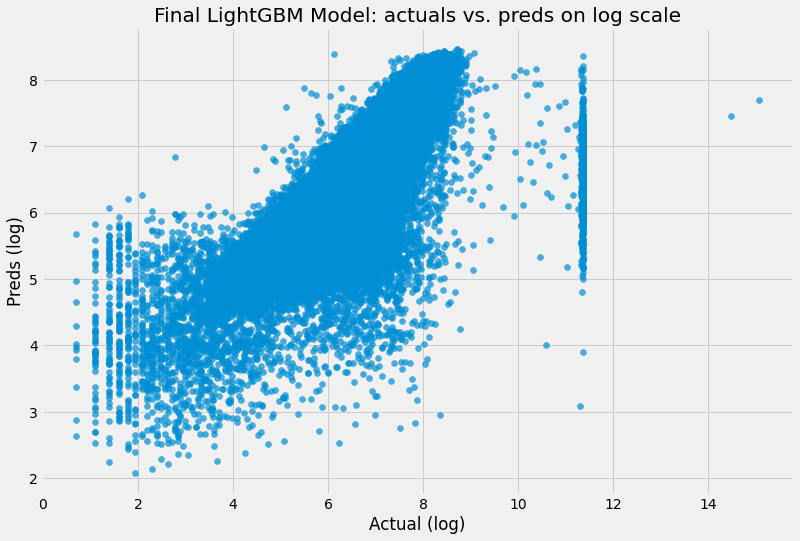

In [430]:
fig, ax = plt.subplots()
ax.scatter(y_test,y_preds_final, alpha=0.7)
ax.set_xlabel('Actual (log)')
ax.set_ylabel('Preds (log)')
ax.set_title('Final LightGBM Model: actuals vs. preds on log scale')
plt.savefig('./plots/residuals_plot.png', bbox_inches='tight')

## Feature Importances

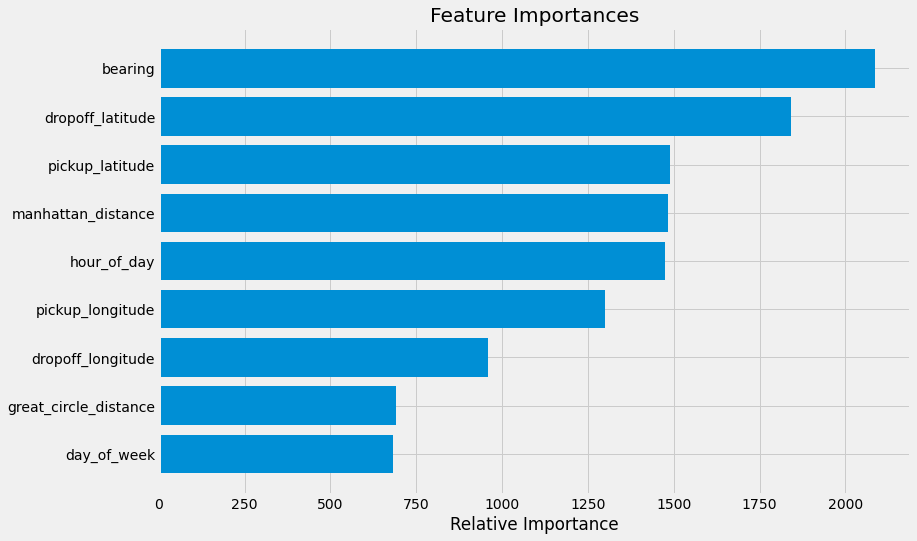

In [396]:
importances = final_lgb.feature_importances_
indices = np.argsort(importances)

features = df_train_feat.loc[:, best_feats_intersection[:best_n_feats]].columns

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig('./plots/lgbm_feature_importances.png', bbox_inches='tight')

# Submit Predictions to .csv for Kaggle

In [431]:
df_test_actual = pd.read_csv('./data_nyc/test.csv')
df_test_actual.shape

(625134, 9)

In [432]:
df_test_actual.head()

id  vendor_id      pickup_datetime  passenger_count  \
0  id3004672          1  2016-06-30 23:59:58                1   
1  id3505355          1  2016-06-30 23:59:53                1   
2  id1217141          1  2016-06-30 23:59:47                1   
3  id2150126          2  2016-06-30 23:59:41                1   
4  id1598245          1  2016-06-30 23:59:33                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.988129        40.732029         -73.990173         40.756680   
1        -73.964203        40.679993         -73.959808         40.655403   
2        -73.997437        40.737583         -73.986160         40.729523   
3        -73.956070        40.771900         -73.986427         40.730469   
4        -73.970215        40.761475         -73.961510         40.755890   

  store_and_fwd_flag  
0                  N  
1                  N  
2                  N  
3                  N  
4                  N

In [433]:
df_test_actual_feat = half_pipeline.transform(df_test_actual[initial_feats])

Time-based features transformed
Distance features calculated
Pickup Clusters Found
Dropoff Clusters Found
Categorical variables dummified


In [434]:
df_test_actual_feat.loc[:,best_feats_intersection[:best_n_feats]].head()

bearing  hour_of_day  dropoff_latitude  pickup_latitude  \
0  106.749322           23         40.756680        40.732029   
1  302.886040           23         40.655403        40.679993   
2  348.844466           23         40.729523        40.737583   
3  200.628779           23         40.730469        40.771900   
4  349.948785           23         40.755890        40.761475   

   manhattan_distance  dropoff_longitude  great_circle_distance  day_of_week  
0          983.432207         -73.990173             789.473665            3  
1         1243.949718         -73.959808             899.671375            3  
2         1500.950597         -73.986160            1277.993177            3  
3         4648.837480         -73.986427            3607.322622            3  
4         1139.447819         -73.961510             983.048299            3

In [450]:
final_preds = final_lgb.predict(df_test_actual_feat.loc[:,best_feats_intersection[:best_n_feats]])
final_preds = np.exp(final_preds)

In [451]:
df_preds = pd.DataFrame(final_preds, index=df_test_actual['id'], columns=['trip_duration'])
df_preds.shape

(625134, 1)

In [452]:
df_preds.head()

trip_duration
id                      
id3004672     777.238826
id3505355     572.334637
id1217141     436.785401
id2150126     908.852096
id1598245     370.874698

In [453]:
df_preds.trip_duration.describe()

count    625134.000000
mean        804.382790
std         575.074110
min           6.411571
25%         408.148213
50%         654.484995
75%        1030.694740
max        5415.192628
Name: trip_duration, dtype: float64

In [454]:
df_preds.to_csv('./data_nyc/preds_v2_20200504.csv', index=True)